In [10]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta, date
import os
import glob 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sqlite3
from matplotlib.ticker import FuncFormatter

In [11]:
plt.rc('text', usetex = True) # latex ticks
plt.rc('text.latex')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ['Computer Modern'],
})
plt.rcParams['axes.linewidth'] = 0.4
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.2
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['ytick.minor.width'] = 0.2

Slide_show_width = 4.71512
Paper_width = 6.30045
Format = 1
if Format == 0:
    Image_width = Slide_show_width
if Format == 1:
    Image_width = Paper_width
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": "Helvetica",
# })

EXTRA_SMALL = 4
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 9

plt.rc('font', size=EXTRA_SMALL)         # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=EXTRA_SMALL)    # fontsize of the tick labels
plt.rc('ytick', labelsize=EXTRA_SMALL)    # fontsize of the tick labels
plt.rc('legend', fontsize=EXTRA_SMALL)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [12]:
total_df = pd.concat([pd.read_csv("Data/ID_auction_preprocessed/2018.csv", index_col=0, parse_dates=True, dayfirst=True), pd.read_csv("Data/ID_auction_preprocessed/2019.csv", index_col=0, parse_dates=True, dayfirst=True), pd.read_csv("Data/ID_auction_preprocessed/2020.csv", index_col=0, parse_dates=True, dayfirst=True)])
new_df = []
for idx in total_df.index:
    new_df.append(pd.DataFrame(columns=['price'], index=pd.date_range(idx, idx + timedelta(minutes=95*15), freq="15min"), data=total_df.loc[idx].to_numpy()))
pd.concat(new_df).sort_index().to_csv("Data/ID_auction_preprocessed/ID_auction_price_2018-2020_preproc.csv")

In [13]:
df_copy = pd.read_csv('Data/preprocessed_dataset.csv', date_format='%s')
df_copy['Datetime offer time'] = pd.to_datetime(df_copy['Datetime offer time'])
df_copy['Datetime from'] = pd.to_datetime(df_copy['Datetime from'])
df_copy_distant = df_copy[df_copy['Datetime from'] - df_copy['Datetime offer time'] > timedelta(hours=3)]

# DA quarterly prices
DA_qtrly = pd.read_csv("Data/Day-Ahead-Quarterly-Data/DA_prices_qtrly_2018_2020_preprocessed.csv", na_values=['n/e'])
DA_qtrly['Datetime from'] = pd.to_datetime(DA_qtrly['Datetime from'], format = "%d.%m.%Y %H:%M")
DA_qtrly = DA_qtrly[DA_qtrly['Datetime from'] > datetime(year=2018,month=11,day=2)]
DA_qtrly['Day-ahead Price [EUR/MWh]']=DA_qtrly['Day-ahead Price [EUR/MWh]'].fillna(DA_qtrly['Day-ahead Price [EUR/MWh]'].rolling(4+1, min_periods=1).mean())
DA_qtrly['Day-ahead Price [EUR/MWh]']=DA_qtrly['Day-ahead Price [EUR/MWh]'].fillna(method='ffill')

# load Load
Load = pd.read_csv("Data/Load/Load_2018-2020.csv", parse_dates = ['Time from'])
Load = Load[Load['Time from'] > datetime(year=2018,month=11,day=2)]
Load[['Actual', 'Forecast']]=Load[['Actual', 'Forecast']].fillna(Load[['Actual', 'Forecast']].rolling(4+1, min_periods=1).mean())

# res generation
gen = pd.read_csv("Data/Generation/Generation_2018-2020.csv", parse_dates = ['Time from'])
gen = gen[gen['Time from'] > datetime(year=2018,month=11,day=2)]
gen[['SPV', 'W']]=gen[['SPV', 'W']].fillna(gen[['SPV', 'W']].rolling(4+1, min_periods=1).mean())

# cross border trade with FR
ge_fr = pd.read_csv("Data/Crossborder/crossborder_ge_fr_2018-2020.csv", parse_dates = ['Time from'])
ge_fr = ge_fr[ge_fr['Time from'] > datetime(year=2018,month=11,day=2)]
ge_fr['DE > FR']=ge_fr['DE > FR'].fillna(ge_fr['DE > FR'].rolling(4+1, min_periods=1).mean())

ID_qtrly = pd.read_csv("Data/ID_auction_preprocessed/ID_auction_price_2018-2020_preproc.csv", index_col=0, parse_dates=True)
ID_qtrly = ID_qtrly[ID_qtrly.index >= datetime(year=2018,month=10,day=31)]

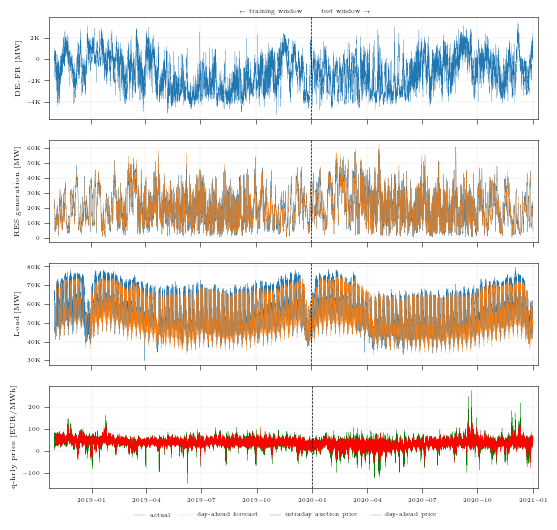

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
f = lambda x, pos: f'{x/10**3:,.0f}K' if x != 0 else 0
# Define the date for the vertical line
split_date = pd.to_datetime("2020-01-01 00:00:00")

# Create subplots
fig, axs = plt.subplots(nrows=4, figsize=(Paper_width, 1.1 * Paper_width))

# Plot the first subplot
ax = axs[0]
ax.plot(ge_fr['Time from'], ge_fr['DE > FR'], lw=0.15)
ax.set_ylabel(r'DE--FR [MW]')
ax.grid(visible=True, linewidth=0.1)
ax.axvline(split_date, color='black', linestyle='--', linewidth=0.5)  # Vertical line at midnight 01-01-2020
ax.text(split_date-timedelta(days=15), ax.get_ylim()[1] * 1.05, r'$\leftarrow$ training window', ha='right', va='bottom')
ax.text(split_date+timedelta(days=15), ax.get_ylim()[1] * 1.05, r'test window $\rightarrow$', ha='left', va='bottom')
ax.yaxis.set_major_formatter(FuncFormatter(f))
ax.margins(x=0.01)

# Plot the second subplot
ax = axs[1]
ax.plot(Load['Time from'], gen['SPV'] + gen['W'], lw=0.2, label='actual')
ax.plot(Load['Time from'], gen['SPV DA'] + gen['W DA'], lw=0.15, label='day-ahead forecast')
ax.grid(visible=True, linewidth=0.1)
ax.set_ylabel('RES generation [MW]')
ax.axvline(split_date, color='black', linestyle='--', linewidth=0.5)  # Vertical line at midnight 01-01-2020
ax.yaxis.set_major_formatter(FuncFormatter(f))
ax.margins(x=0.01)

# Plot the third subplot
ax = axs[2]
ax.plot(Load['Time from'], Load['Actual'], lw=0.2)
ax.plot(Load['Time from'], Load['Forecast'], lw=0.15)
ax.grid(visible=True, linewidth=0.1)
ax.set_ylabel('Load [MW]')
ax.axvline(split_date, color='black', linestyle='--', linewidth=0.5)  # Vertical line at midnight 01-01-2020
ax.yaxis.set_major_formatter(FuncFormatter(f))
ax.margins(x=0.01)

# Plot the fourth subplot
ax = axs[3]
ax.plot(ID_qtrly.index, ID_qtrly.price, lw=0.2, label='intraday auction price', color='green')
ax.plot(DA_qtrly['Datetime from'], DA_qtrly['Day-ahead Price [EUR/MWh]'], lw=0.15, label='day-ahead price', color='red')
ax.set_ylabel('q-hrly price [EUR/MWh]')
ax.grid(visible=True, linewidth=0.1)
ax.axvline(split_date, color='black', linestyle='--', linewidth=0.5)  # Vertical line at midnight 01-01-2020
ax.margins(x=0.01)

# Adjust and save the figure
fig.legend(loc='outside lower center', ncol=4, frameon=False, bbox_to_anchor=(0.5, 0.15))
fig.autofmt_xdate(rotation=0, ha='center')

plt.savefig('Paper_Figures/exogenous_variables.pdf', bbox_inches='tight')


# Analysis of proportion of crossborder trades

In [3]:
plain_data = pd.read_csv('Data/Transactions/concatenated_table.csv')
print("Bought from: ", plain_data.groupby('Area Buy')['Volume (MW)'].sum().sort_values()/np.sum(plain_data.groupby('Area Buy')['Volume (MW)'].sum().sort_values()))
print("Sold to: ", plain_data.groupby('Market Area Sell')['Volume (MW)'].sum().sort_values()/np.sum(plain_data.groupby('Market Area Sell')['Volume (MW)'].sum()))

Bought from:  Area Buy
NO4     1.743767e-07
NO3     3.904412e-07
NO1     1.988810e-06
NO5     2.536343e-06
NO2     2.690892e-06
SE2     1.231364e-05
SE4     2.249358e-05
SE1     2.448494e-05
FI      4.429169e-05
SE3     9.116396e-05
DK2     5.686451e-04
DK1     1.000222e-03
BE      7.283260e-03
NL      1.719334e-02
AT      1.780483e-02
FR      2.701628e-02
XBID    7.585446e-02
DE      8.530764e-01
Name: Volume (MW), dtype: float64
Sold to:  Market Area Sell
NO4     1.418400e-07
NO3     8.764592e-07
SE2     6.401609e-06
NO5     9.155542e-06
NO1     1.243616e-05
SE1     2.055968e-05
SE4     2.186420e-05
NO2     4.262164e-05
FI      8.235310e-05
SE3     2.019410e-04
DK2     5.484855e-04
DK1     1.023960e-03
BE      7.387143e-03
NL      1.468460e-02
AT      2.276870e-02
FR      3.245621e-02
XBID    8.139322e-02
DE      8.393393e-01
Name: Volume (MW), dtype: float64


## Prices and volume exploratory analysis

In [3]:
df_copy_hourly = pd.read_csv('Data/hourly_preprocessed_dataset.csv', date_format='%s')
df_copy_hourly['Datetime offer time'] = pd.to_datetime(df_copy_hourly['Datetime offer time'])
df_copy_hourly['Datetime from'] = pd.to_datetime(df_copy_hourly['Datetime from'])

In [4]:
df_copy = pd.read_csv('Data/preprocessed_dataset.csv', date_format='%s')
df_copy['Datetime offer time'] = pd.to_datetime(df_copy['Datetime offer time'])
df_copy['Datetime from'] = pd.to_datetime(df_copy['Datetime from'])

Statistics for trades <3h before the delivery

In [8]:
less_3h = df_copy_hourly[df_copy_hourly['Datetime from'] - df_copy_hourly['Datetime offer time'] < timedelta(hours=3)][['Price (EUR)','Volume (MW)']].describe()
less_3h.to_csv('Paper_Tables/less_than_3h_stats.csv')
less_3h

Price (EUR)   Volume (MW)
count  2.711079e+07  2.711079e+07
mean   3.656122e+01  2.983833e+00
std    2.639114e+01  3.880396e+00
min   -3.000000e+03  1.000000e-01
25%    2.661000e+01  5.000000e-01
50%    3.660000e+01  2.000000e+00
75%    4.680000e+01  5.000000e+00
max    6.200000e+03  7.800000e+02

In [7]:
less_3h = df_copy[df_copy['Datetime from'] - df_copy['Datetime offer time'] < timedelta(hours=3)][['Price (EUR)','Volume (MW)']].describe()
less_3h.to_csv('Paper_Tables/less_than_3h_stats.csv')
less_3h

Price (EUR)   Volume (MW)
count  3.359668e+07  3.359668e+07
mean   3.618424e+01  1.863402e+00
std    2.804542e+01  2.361050e+00
min   -5.999000e+03  1.000000e-01
25%    2.500000e+01  4.000000e-01
50%    3.600000e+01  1.000000e+00
75%    4.739000e+01  2.600000e+00
max    7.999000e+03  3.010000e+02

Statistics for trades >3h before the delivery

In [9]:
more_3h = df_copy_hourly[df_copy_hourly['Datetime from'] - df_copy_hourly['Datetime offer time'] > timedelta(hours=3)][['Price (EUR)','Volume (MW)']].describe()
more_3h.to_csv('Paper_Tables/more_than_3h_stats.csv')
more_3h

Price (EUR)   Volume (MW)
count  1.158006e+07  1.158006e+07
mean   3.673164e+01  3.288214e+00
std    2.122241e+01  5.334374e+00
min   -1.999200e+02  1.000000e-01
25%    2.699000e+01  8.000000e-01
50%    3.699000e+01  2.300000e+00
75%    4.675000e+01  5.000000e+00
max    6.998000e+02  8.830000e+02

In [13]:
more_3h = df_copy[df_copy['Datetime from'] - df_copy['Datetime offer time'] > timedelta(hours=3)][['Price (EUR)','Volume (MW)']].describe()
more_3h.to_csv('Paper_Tables/more_than_3h_stats.csv')
more_3h

Price (EUR)   Volume (MW)
count  8.744774e+06  8.744774e+06
mean   3.649961e+01  1.578525e+00
std    2.291518e+01  1.845516e+00
min   -5.694000e+02  1.000000e-01
25%    2.573000e+01  4.000000e-01
50%    3.670000e+01  1.000000e+00
75%    4.795000e+01  2.100000e+00
max    1.244690e+03  3.093000e+02

[statistics of price and volume <3h before delivery]/[statistics of price and volume >3h before delivery]

In [14]:
df_copy[df_copy['Datetime from'] - df_copy['Datetime offer time'] < timedelta(hours=3)][['Price (EUR)','Volume (MW)']].describe()/df_copy[df_copy['Datetime from'] - df_copy['Datetime offer time'] > timedelta(hours=3)][['Price (EUR)','Volume (MW)']].describe()

Price (EUR)  Volume (MW)
count     3.841915     3.841915
mean      0.991360     1.180470
std       1.223879     1.279344
min      10.535652     1.000000
25%       0.971628     1.000000
50%       0.980926     1.000000
75%       0.988321     1.238095
max       6.426500     0.973165

In [13]:
import plotly.graph_objects as go

fig = go.Figure()

df_day = df_copy[df_copy['Datetime from'].dt.date == datetime(2020, 3, 29).date()]

for dfrom in np.unique(df_day['Datetime from']):
    d_day_delivery = df_day[df_day['Datetime from'] == dfrom].sort_values(by='Datetime offer time')
    fig.add_trace(go.Scatter(x=d_day_delivery['Datetime offer time'], y=d_day_delivery['Price (EUR)'],
                             mode='lines',
                             name=str(dfrom)))

df_day = df_copy_hourly[df_copy_hourly['Datetime from'].dt.date == datetime(2020, 3, 29).date()]

for dfrom in np.unique(df_day['Datetime from']):
    d_day_delivery = df_day[df_day['Datetime from'] == dfrom].sort_values(by='Datetime offer time')
    fig.add_trace(go.Scatter(x=d_day_delivery['Datetime offer time'], y=d_day_delivery['Price (EUR)'],
                             mode='lines',
                             name='hrly ' + str(dfrom)))

fig.update_layout(title='Delivery Prices over Time',
                  xaxis_title='Datetime offer time',
                  yaxis_title='Price (EUR)',
                  legend_title='Datetime from')

fig.write_html('test_hrly.html')
fig.show()


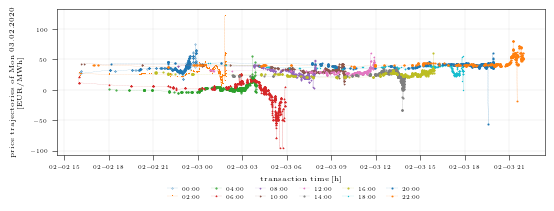

In [136]:
import plotly.graph_objects as go

fig, ax = plt.subplots(figsize=(Image_width, 0.3*Image_width))

df_day = df_copy[df_copy['Datetime from'].dt.date == datetime(2020, 2, 3).date()]

markers = ['.',',','o','v','^','<','>','h','H','+','D','d','|','_']
idx = 0
for dfrom in np.unique(df_day['Datetime from']):
    if pd.to_datetime(dfrom).minute == 0 and pd.to_datetime(dfrom).hour%2 == 0:
        d_day_delivery = df_day[df_day['Datetime from'] == dfrom].sort_values(by='Datetime offer time')
        markersize = 0.3
        if markers[idx] == '+':
            markersize = 0.7
        ax.plot(d_day_delivery['Datetime offer time'], d_day_delivery['Price (EUR)'], label = pd.to_datetime(dfrom).strftime("%H:%M"), marker=markers[idx], markersize=0.5, lw=0.1, ls='--')
        idx += 1
fig.legend(loc='outside lower center', ncol=6, frameon=False, bbox_to_anchor=(0.5, -0.15))
ax.set_xlabel('transaction time [h]')
ax.set_ylabel('price trajectories of Mon 03.02.2020\n[EUR/MWh]')
ax.grid(visible=True, linewidth=0.1)
plt.savefig(f'Paper_Figures/example_of_trajectories.pdf', bbox_inches = 'tight')

# 3D price and volume analysis

C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2504397464.py:38: RuntimeWarning: Mean of empty slice
  print(np.nanmin(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]), np.nanmax(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]))
C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2504397464.py:40: RuntimeWarning: Mean of empty slice
  im = ax.imshow(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1], origin='lower', aspect='auto',


-20.5836012942613 95.00917857142856


C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2504397464.py:38: RuntimeWarning: Mean of empty slice
  print(np.nanmin(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]), np.nanmax(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]))
C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2504397464.py:40: RuntimeWarning: Mean of empty slice
  im = ax.imshow(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1], origin='lower', aspect='auto',


16.97177070266604 68.70666461038962


C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2504397464.py:38: RuntimeWarning: Mean of empty slice
  print(np.nanmin(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]), np.nanmax(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]))
C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2504397464.py:40: RuntimeWarning: Mean of empty slice
  im = ax.imshow(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1], origin='lower', aspect='auto',


1.8357566137566126 63.072529075091566


C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2504397464.py:38: RuntimeWarning: Mean of empty slice
  print(np.nanmin(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]), np.nanmax(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]))
C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2504397464.py:40: RuntimeWarning: Mean of empty slice
  im = ax.imshow(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1], origin='lower', aspect='auto',


-21.771473183784533 51.947702020202016


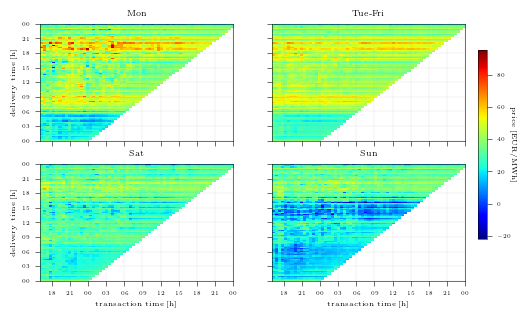

In [112]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(Paper_width,0.6*Paper_width), sharex=True, sharey=True)

titles = ['Mon', 'Tue-Fri', 'Sat', 'Sun']

collect_matrices = [] # comment if You run 2nd time and set False in line 7

for idx, wday, ax in zip(range(4), [[0],[1,2,3,4],[5],[6]], axs.flat):
    if True: # change to false if You run cell 2nd time
        df_copy_0 = df_copy[['Datetime from', 'Datetime offer time', 'Price (EUR)']].copy(deep=True)
        df_copy_0 = df_copy_0[(df_copy_0['Datetime from'].dt.date != df_copy_0['Datetime offer time'].dt.date) & (df_copy_0['Datetime from'].dt.weekday.isin(wday))]
        df_copy_0['Datetime offer time'] = pd.to_datetime(df_copy_0['Datetime offer time']).dt.time
        df_copy_0['Datetime from'] = pd.to_datetime(df_copy_0['Datetime from']).dt.time

        price_avged = df_copy_0.groupby(['Datetime from', 'Datetime offer time']).mean()['Price (EUR)']

        total_matrix_0 = np.zeros((96, 24*60))*np.nan
        for i, group in enumerate(price_avged.groupby(level=0)):
            for j, g in enumerate(group[1].groupby(level=1)):
                total_matrix_0[i, (datetime.combine(date.today(), g[0]) - datetime.today().replace(hour=0,minute=0,second=0,microsecond=0)).seconds//60] = g[1].to_numpy()[0]
        df_copy_1 = df_copy[['Datetime from', 'Datetime offer time', 'Price (EUR)']].copy(deep=True)
        df_copy_1 = df_copy_1[(df_copy_1['Datetime from'].dt.date == df_copy_1['Datetime offer time'].dt.date) & (df_copy_1['Datetime from'].dt.weekday.isin(wday))]
        df_copy_1['Datetime offer time'] = pd.to_datetime(df_copy_1['Datetime offer time']).dt.time
        df_copy_1['Datetime from'] = pd.to_datetime(df_copy_1['Datetime from']).dt.time

        price_avged = df_copy_1.groupby(['Datetime from', 'Datetime offer time']).mean()['Price (EUR)']

        total_matrix_1 = np.zeros((96, 24*60))*np.nan
        for i, group in enumerate(price_avged.groupby(level=0)):
            for j, g in enumerate(group[1].groupby(level=1)):
                total_matrix_1[i+1, (datetime.combine(date.today(), g[0]) - datetime.today().replace(hour=0,minute=0,second=0,microsecond=0)).seconds//60] = g[1].to_numpy()[0]

        total_matrix = np.hstack((total_matrix_0, total_matrix_1))

        collect_matrices.append(total_matrix)
    else:
        total_matrix = collect_matrices[idx]

    print(np.nanmin(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]), np.nanmax(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]))

    im = ax.imshow(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1], origin='lower', aspect='auto',
                cmap='jet',
                extent=[datetime.today().replace(hour=16,minute=0,second=0,microsecond=0), date.today() + timedelta(days=2), date.today() + timedelta(days=1), date.today() + timedelta(days=2) - timedelta(minutes=15)],
                interpolation='none',
                vmin=-22, vmax=95)

    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
    ax.yaxis_date()
    ax.yaxis.set_major_formatter(mdates.DateFormatter("%H"))

    # cbar = fig.colorbar(im)
    # cbar.set_label('price [EUR/MWh]', rotation=270, labelpad=12)
    if idx > 1:
        ax.set_xlabel('transaction time [h]')
    if idx in [0,2]:
        ax.set_ylabel('delivery time [h]')
    ax.grid(visible=True, linewidth=0.1)
    ax.set_title(titles[idx])
fig.autofmt_xdate(rotation=0, ha='center')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.31, 0.015, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('price [EUR/MWh]', rotation=270, labelpad=5)

plt.savefig('Paper_Figures/mon_aggtuefri_sat_sun_3D_prices.pdf', bbox_inches = 'tight')

21146.0 8.0
21328.75 14.5
19748.0 8.0
19175.0 9.0


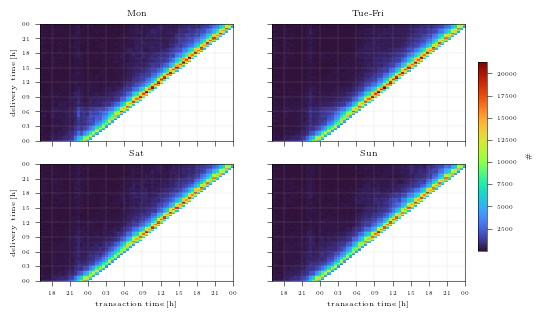

In [113]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(Paper_width,0.6*Paper_width), sharex=True, sharey=True)

titles = ['Mon', 'Tue-Fri', 'Sat', 'Sun']

for idx, wday, ax in zip(range(4), [[0],[1,2,3,4],[5],[6]], axs.flat):
    df_copy_0 = df_copy[['Datetime from', 'Datetime offer time', 'Price (EUR)']].copy(deep=True)
    df_copy_0 = df_copy_0[(df_copy_0['Datetime from'].dt.date != df_copy_0['Datetime offer time'].dt.date) & (df_copy_0['Datetime from'].dt.weekday.isin(wday))]
    df_copy_0['Datetime offer time'] = pd.to_datetime(df_copy_0['Datetime offer time']).dt.time
    df_copy_0['Datetime from'] = pd.to_datetime(df_copy_0['Datetime from']).dt.time

    price_avged = df_copy_0.groupby(['Datetime from', 'Datetime offer time']).count()['Price (EUR)']

    total_matrix_0 = np.zeros((96, 24*60))*np.nan
    for i, group in enumerate(price_avged.groupby(level=0)):
        for j, g in enumerate(group[1].groupby(level=1)):
            total_matrix_0[i, (datetime.combine(date.today(), g[0]) - datetime.today().replace(hour=0,minute=0,second=0,microsecond=0)).seconds//60] = g[1].to_numpy()[0]
    df_copy_1 = df_copy[['Datetime from', 'Datetime offer time', 'Price (EUR)']].copy(deep=True)
    df_copy_1 = df_copy_1[(df_copy_1['Datetime from'].dt.date == df_copy_1['Datetime offer time'].dt.date) & (df_copy_1['Datetime from'].dt.weekday.isin(wday))]
    df_copy_1['Datetime offer time'] = pd.to_datetime(df_copy_1['Datetime offer time']).dt.time
    df_copy_1['Datetime from'] = pd.to_datetime(df_copy_1['Datetime from']).dt.time

    price_avged = df_copy_1.groupby(['Datetime from', 'Datetime offer time']).count()['Price (EUR)']

    total_matrix_1 = np.zeros((96, 24*60))*np.nan
    for i, group in enumerate(price_avged.groupby(level=0)):
        for j, g in enumerate(group[1].groupby(level=1)):
            total_matrix_1[i+1, (datetime.combine(date.today(), g[0]) - datetime.today().replace(hour=0,minute=0,second=0,microsecond=0)).seconds//60] = g[1].to_numpy()[0]

    total_matrix = np.hstack((total_matrix_0, total_matrix_1))

    if idx == 1:
        total_matrix = total_matrix/4

    sum_matrix = np.nansum(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]
    sum_matrix[sum_matrix == 0] = np.nan

    print(np.nanmax(sum_matrix), np.nanmin(sum_matrix))

    im = ax.imshow(sum_matrix, origin='lower', aspect='auto',
                cmap='turbo',
                extent=[datetime.today().replace(hour=16,minute=0,second=0,microsecond=0), date.today() + timedelta(days=2), date.today() + timedelta(days=1), date.today() + timedelta(days=2) - timedelta(minutes=15)],
                interpolation='none',
                vmin=8.0, vmax=21328.75)

    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
    ax.yaxis_date()
    ax.yaxis.set_major_formatter(mdates.DateFormatter("%H"))

    if idx > 1:
        ax.set_xlabel('transaction time [h]')
    if idx in [0,2]:
        ax.set_ylabel('delivery time [h]')
    ax.grid(visible=True, linewidth=0.1)
    ax.set_title(titles[idx])

fig.autofmt_xdate(rotation=0, ha='center')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.28, 0.015, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('\#', rotation=270, labelpad=11)

plt.savefig('Paper_Figures/mon_aggtuefri_sat_sun_3D_avg_daily_trades_no.pdf', bbox_inches = 'tight')

C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2329724152.py:60: RuntimeWarning: Mean of empty slice
  print(np.nanmax(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]), np.nanmin(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]))
C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2329724152.py:61: RuntimeWarning: Mean of empty slice
  im = ax.imshow(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1], origin='lower', aspect='auto',


57.68355067309902 0.019445436482630897


C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2329724152.py:60: RuntimeWarning: Mean of empty slice
  print(np.nanmax(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]), np.nanmin(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]))
C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2329724152.py:61: RuntimeWarning: Mean of empty slice
  im = ax.imshow(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1], origin='lower', aspect='auto',


77.45597441758358 0.49417173505020545


C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2329724152.py:60: RuntimeWarning: Mean of empty slice
  print(np.nanmax(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]), np.nanmin(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]))
C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2329724152.py:61: RuntimeWarning: Mean of empty slice
  im = ax.imshow(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1], origin='lower', aspect='auto',


35.80679919129356 0.0


C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2329724152.py:60: RuntimeWarning: Mean of empty slice
  print(np.nanmax(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]), np.nanmin(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]))
C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2329724152.py:61: RuntimeWarning: Mean of empty slice
  im = ax.imshow(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1], origin='lower', aspect='auto',


46.32558200932583 0.2441998088025988


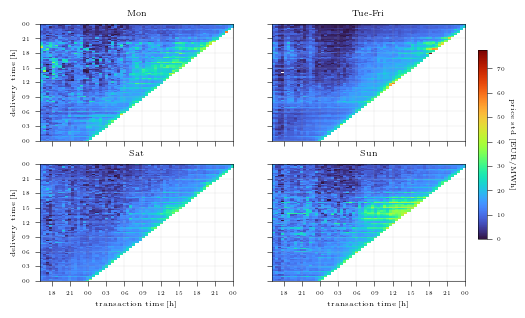

In [114]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(Paper_width,0.6*Paper_width), sharex=True, sharey=True)

titles = ['Mon', 'Tue-Fri', 'Sat', 'Sun']

for idx, wday, ax in zip(range(4), [[0],[1,2,3,4],[5],[6]], axs.flat):
    if idx != 1:
        df_copy_0 = df_copy[['Datetime from', 'Datetime offer time', 'Price (EUR)']].copy(deep=True)
        df_copy_0 = df_copy_0[(df_copy_0['Datetime from'].dt.date != df_copy_0['Datetime offer time'].dt.date) & (df_copy_0['Datetime from'].dt.weekday.isin(wday))]
        df_copy_0['Datetime offer time'] = pd.to_datetime(df_copy_0['Datetime offer time']).dt.time
        df_copy_0['Datetime from'] = pd.to_datetime(df_copy_0['Datetime from']).dt.time

        price_avged = df_copy_0.groupby(['Datetime from', 'Datetime offer time']).std()['Price (EUR)']

        total_matrix_0 = np.zeros((96, 24*60))*np.nan
        for i, group in enumerate(price_avged.groupby(level=0)):
            for j, g in enumerate(group[1].groupby(level=1)):
                total_matrix_0[i, (datetime.combine(date.today(), g[0]) - datetime.today().replace(hour=0,minute=0,second=0,microsecond=0)).seconds//60] = g[1].to_numpy()[0]
        df_copy_1 = df_copy[['Datetime from', 'Datetime offer time', 'Price (EUR)']].copy(deep=True)
        df_copy_1 = df_copy_1[(df_copy_1['Datetime from'].dt.date == df_copy_1['Datetime offer time'].dt.date) & (df_copy_1['Datetime from'].dt.weekday.isin(wday))]
        df_copy_1['Datetime offer time'] = pd.to_datetime(df_copy_1['Datetime offer time']).dt.time
        df_copy_1['Datetime from'] = pd.to_datetime(df_copy_1['Datetime from']).dt.time

        price_avged = df_copy_1.groupby(['Datetime from', 'Datetime offer time']).std()['Price (EUR)']

        total_matrix_1 = np.zeros((96, 24*60))*np.nan
        for i, group in enumerate(price_avged.groupby(level=0)):
            for j, g in enumerate(group[1].groupby(level=1)):
                total_matrix_1[i+1, (datetime.combine(date.today(), g[0]) - datetime.today().replace(hour=0,minute=0,second=0,microsecond=0)).seconds//60] = g[1].to_numpy()[0]
        total_matrix = np.hstack((total_matrix_0, total_matrix_1))

    else:
        total_matrix_4_days = np.zeros((96, 48*60))
        for day in wday:
            df_copy_0 = df_copy[['Datetime from', 'Datetime offer time', 'Price (EUR)']].copy(deep=True)
            df_copy_0 = df_copy_0[(df_copy_0['Datetime from'].dt.date != df_copy_0['Datetime offer time'].dt.date) & (df_copy_0['Datetime from'].dt.weekday.isin([day]))]
            df_copy_0['Datetime offer time'] = pd.to_datetime(df_copy_0['Datetime offer time']).dt.time
            df_copy_0['Datetime from'] = pd.to_datetime(df_copy_0['Datetime from']).dt.time

            price_avged = df_copy_0.groupby(['Datetime from', 'Datetime offer time']).std()['Price (EUR)']

            total_matrix_0 = np.zeros((96, 24*60))
            for i, group in enumerate(price_avged.groupby(level=0)):
                for j, g in enumerate(group[1].groupby(level=1)):
                    total_matrix_0[i, (datetime.combine(date.today(), g[0]) - datetime.today().replace(hour=0,minute=0,second=0,microsecond=0)).seconds//60] = g[1].to_numpy()[0]
            df_copy_1 = df_copy[['Datetime from', 'Datetime offer time', 'Price (EUR)']].copy(deep=True)
            df_copy_1 = df_copy_1[(df_copy_1['Datetime from'].dt.date == df_copy_1['Datetime offer time'].dt.date) & (df_copy_1['Datetime from'].dt.weekday.isin([day]))]
            df_copy_1['Datetime offer time'] = pd.to_datetime(df_copy_1['Datetime offer time']).dt.time
            df_copy_1['Datetime from'] = pd.to_datetime(df_copy_1['Datetime from']).dt.time

            price_avged = df_copy_1.groupby(['Datetime from', 'Datetime offer time']).std()['Price (EUR)']

            total_matrix_1 = np.zeros((96, 24*60))
            for i, group in enumerate(price_avged.groupby(level=0)):
                for j, g in enumerate(group[1].groupby(level=1)):
                    total_matrix_1[i+1, (datetime.combine(date.today(), g[0]) - datetime.today().replace(hour=0,minute=0,second=0,microsecond=0)).seconds//60] = g[1].to_numpy()[0]
            total_matrix = np.hstack((total_matrix_0, total_matrix_1))
            total_matrix_4_days = np.sum(np.dstack((total_matrix_4_days,total_matrix)),2)
        total_matrix = total_matrix_4_days/4
        total_matrix[total_matrix == 0] = np.nan
    print(np.nanmax(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]), np.nanmin(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]))
    im = ax.imshow(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1], origin='lower', aspect='auto',
                cmap='turbo',
                extent=[datetime.today().replace(hour=16,minute=0,second=0,microsecond=0), date.today() + timedelta(days=2), date.today() + timedelta(days=1), date.today() + timedelta(days=2) - timedelta(minutes=15)],
                interpolation='none',
                vmin=0, vmax=77.45597441758358)

    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
    ax.yaxis_date()
    ax.yaxis.set_major_formatter(mdates.DateFormatter("%H"))

    if idx > 1:
        ax.set_xlabel('transaction time [h]')
    if idx in [0,2]:
        ax.set_ylabel('delivery time [h]')
    ax.grid(visible=True, linewidth=0.1)
    ax.set_title(titles[idx])

fig.autofmt_xdate(rotation=0, ha='center')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.31, 0.015, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('price std [EUR/MWh]', rotation=270, labelpad=8)
plt.savefig('Paper_Figures/mon_aggtuefri_sat_sun_3D_avg_daily_std.pdf', bbox_inches = 'tight')

In [8]:
df = pd.read_csv('Data/preprocessed_dataset.csv')

con = sqlite3.connect('Forecasting/data_ID.db')
sql_str = f"SELECT * FROM with_dummies;" # load only the data required for simu, so up to trade time
daily_data = pd.read_sql(sql_str, con)
daily_data['Time'] = pd.to_datetime(daily_data['Time'])

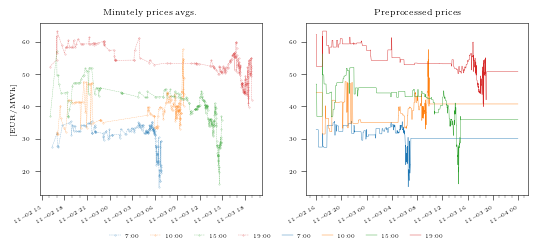

In [9]:
fig, axs = plt.subplots(ncols=2, figsize=(Image_width, 0.4*Image_width))

ax = axs[0]
ttd_minutely = pd.date_range(datetime(year=2020,month=11,day=2,hour=16), datetime(year=2020,month=11,day=4,hour=0), freq='1min')
idxs = [int(7*4), int(10*4), int(15*4)]
labels = ['7:00','10:00','15:00', '19:00']
for d_i, dat in enumerate(['2020-11-03 07:00:00','2020-11-03 10:00:00','2020-11-03 15:00:00', '2020-11-03 19:00:00']):
    current_data_avg = df[df['Datetime from'] == dat].groupby('Time to delivery', as_index=False)
    price = []
    ttd = []
    for group in current_data_avg:
        price.append(np.sum(group[1]['Price (EUR)'].to_numpy()*group[1]['Volume (MW)'].to_numpy())/np.sum(group[1]['Volume (MW)']))
        ttd.append(pd.to_datetime(dat)  - timedelta(minutes = group[1]['Time to delivery'].to_numpy()[0]))
    ax.plot(ttd, price,marker='.',ls='--', markersize=0.5,alpha=0.5,label=labels[d_i], lw=0.3)
    # ax.plot(ttd_minutely, preproc_15[-(31+28),idxs[d_i], :])
ax.set_ylabel('[EUR/MWh]')
hours = mdates.HourLocator(interval = 1)
ax.xaxis.set_minor_locator(hours)
ax.set_title("Minutely prices avgs.")
# plt.legend(['delivery 7:00','delivery 10:00','delivery 15:00', 'delivery 19:00'], ncols=2)
plt.grid(which='both', axis='x')

ax = axs[1]
ax.plot(daily_data[daily_data['Day'] == 733]['Time'], daily_data[daily_data['Day'] == 733]['28'],label=labels[0], lw=0.3)
ax.plot(daily_data[daily_data['Day'] == 733]['Time'], daily_data[daily_data['Day'] == 733]['40'],label=labels[1], lw=0.3)
ax.plot(daily_data[daily_data['Day'] == 733]['Time'], daily_data[daily_data['Day'] == 733]['60'],label=labels[2], lw=0.3)
ax.plot(daily_data[daily_data['Day'] == 733]['Time'], daily_data[daily_data['Day'] == 733]['76'],label=labels[3], lw=0.3)
ax.set_title("Preprocessed prices")
ax.xaxis.set_minor_locator(hours)
plt.grid(which='both', axis='x')
plt.gcf().autofmt_xdate()
fig.legend(loc='outside lower center', ncol=8,frameon=False,borderaxespad=0, bbox_to_anchor=(0.5, 0.02))
fig.autofmt_xdate()
plt.savefig(f'Paper_Figures/example_of_preprocessing.pdf', bbox_inches = 'tight')

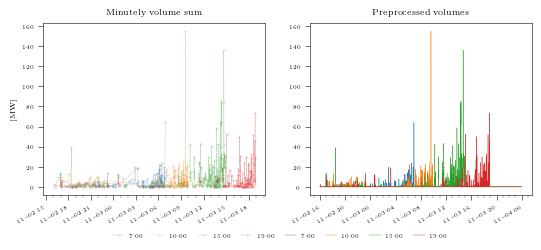

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(Image_width, 0.4*Image_width))

ax = axs[0]
ttd_minutely = pd.date_range(datetime(year=2020,month=11,day=2,hour=16), datetime(year=2020,month=11,day=4,hour=0), freq='1min')
idxs = [int(7*4), int(10*4), int(15*4)]
labels = ['7:00','10:00','15:00', '19:00']
for d_i, dat in enumerate(['2020-11-03 07:00:00','2020-11-03 10:00:00','2020-11-03 15:00:00', '2020-11-03 19:00:00']):
    current_data_avg = df[df['Datetime from'] == dat].groupby('Time to delivery', as_index=False)
    price = []
    ttd = []
    for group in current_data_avg:
        price.append(np.sum(group[1]['Volume (MW)']))
        ttd.append(pd.to_datetime(dat) - timedelta(minutes = group[1]['Time to delivery'].to_numpy()[0]))
    ax.plot(ttd, price,marker='.',ls='--', markersize=0.5,alpha=0.5,label=labels[d_i], lw=0.3)
    # ax.plot(ttd_minutely, preproc_15[-(31+28),idxs[d_i], :])
# ax.set_xlabel('time [min]')
ax.set_ylabel('[MW]')
hours = mdates.HourLocator(interval = 1)
ax.xaxis.set_minor_locator(hours)
ax.set_title("Minutely volume sum")
# plt.legend(['delivery 7:00','delivery 10:00','delivery 15:00', 'delivery 19:00'], ncols=2)
plt.grid(which='both', axis='x')

ax = axs[1]
ax.plot(daily_data[daily_data['Day'] == 733]['Time'], daily_data[daily_data['Day'] == 733]['124'],label=labels[0], lw=0.3)
ax.plot(daily_data[daily_data['Day'] == 733]['Time'], daily_data[daily_data['Day'] == 733]['136'],label=labels[1], lw=0.3)
ax.plot(daily_data[daily_data['Day'] == 733]['Time'], daily_data[daily_data['Day'] == 733]['156'],label=labels[2], lw=0.3)
ax.plot(daily_data[daily_data['Day'] == 733]['Time'], daily_data[daily_data['Day'] == 733]['172'],label=labels[3], lw=0.3)
ax.set_title("Preprocessed volumes")
ax.xaxis.set_minor_locator(hours)
plt.grid(which='both', axis='x')
plt.gcf().autofmt_xdate()
fig.legend(loc='outside lower center', ncol=8,frameon=False,borderaxespad=0, bbox_to_anchor=(0.5, 0.02))
# fig.autofmt_xdate()
plt.savefig(f'Paper_Figures/volume_example_of_preprocessing.pdf', bbox_inches = 'tight')